In [1]:
from numpy import genfromtxt
import csv
import numpy
import random
import pandas
import re
import time

from IPython.display import Audio, display
def allDone():
    urL = 'https://www.wavsource.com/snds_2020-10-01_3728627494378403/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
# allDone()

my_seed = 666
random.seed(my_seed)

In [2]:
amino_acids = 'XWGSAELQDMPFTRIHVNCY_K'

my_fams = ['PKA', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKC', 'PIKK']

data_file = 'data_raw__for_nerds/'

In [4]:
test = genfromtxt(data_file + 'uniprot_gene_synsdict_19.01.07.csv', delimiter=',',dtype='U')
uniprot_dict = {}  # { ..., uniprot id: [gene, [synonyms]] ,... }
for line in test:
    uniprot = line[0]
    gene = line[1]
    synonyms = list(set([x for x in line[2:] if x]))
    uniprot_dict[uniprot] = [gene,synonyms]
    
for k,v in uniprot_dict.items():
    v[1] = [x.upper() for x in v[1]]
    
print ("number of kinases:",len(uniprot_dict))
print (uniprot_dict['P42680'])

number of kinases: 534
['TEC', ['PSCTK4', 'TEC', 'P42680']]


In [6]:
content_fams = genfromtxt(data_file + 'kinase_fams.csv', delimiter=',',dtype='U')

fams = list(set([x[2].upper() for x in content_fams[1:]]))
gene_symbols = list(set([x[3] for x in content_fams[1:]]))
fams_and_symbs = [ [x[2],x[3]] for x in content_fams[1:]]

kin_to_fam = { x[3].upper():x[2].upper() for x in content_fams[1:] }

### had to manually google these names. i hope they're right
kin_to_fam['PKN1'] = 'PKN'
kin_to_fam['PKN2'] = 'PKN'
kin_to_fam['PDPK1'] = 'PDK1'
kin_to_fam['MAPKAPK3'] = 'MAPKAPK'
kin_to_fam['PRKCA'] = 'PKC'
kin_to_fam['ALPK3'] = 'ALPHA'
kin_to_fam['SGK494'] = 'RSKR'
kin_to_fam['NIM1K'] = 'ALPHA'
kin_to_fam['FYN'] = 'SRC'
kin_to_fam['MTOR'] = 'PIKK'
kin_to_fam['PKG/CGK'] = 'PKG'
kin_to_fam['PRKCB'] = 'PKC'
kin_to_fam['GRK2'] = 'GRK'
kin_to_fam['SGK1'] = 'SGK'
kin_to_fam['CAM-KII'] = 'CAMK2'
kin_to_fam['CAMKII'] = 'CAMK2'
kin_to_fam['PKG2/CGK-II'] ='PKG'
kin_to_fam['PKG2/CGK-I'] ='PKG'
kin_to_fam['MAP2K'] ='STE7'
kin_to_fam['RSK-5'] = 'RSK'
kin_to_fam['RSK-4'] = 'RSK'
kin_to_fam['RSK-3'] = 'RSK'
kin_to_fam['RSK-2'] = 'RSK'
kin_to_fam['RSK-1'] = 'RSK'
kin_to_fam['CAM-KI'] = 'CAMK1'
kin_to_fam['CDK1'] = 'CDK'

In [7]:
k_to_ms = {k.upper():[] for k in fams} # kinase to motifs dictionary
print(len(k_to_ms))

motifs = []
kinases = []
motifs_without_kinase = 0
motifs_with_kinase = 0

133


In [10]:
#####################################
############ PHOSPHO_ELM ############
#####################################

with open (data_file + 'PhosphoELM_vertebrate',encoding="ISO-8859-1") as file:
    reader = csv.reader(file, delimiter='\t')
    content = [x for x in reader]
    
for i,line in enumerate(content[1:]):
    
    front_buff = False
    back_buff = False
    
    seq = line[1]
    center_idx = int(line[2])-1
    
    ### need to check if motif is shorter than 15 aa ... 
    start = center_idx - 7
    if start<0:
        front_buff = abs(start) * "_"
    end = center_idx + 8
    if end>=len(seq):
        back_buff = (end - len(seq)) * "_"
    
    if front_buff:
        motif = front_buff + seq[:end]
    elif back_buff:
        motif = seq[start:] + back_buff
    else:
        motif = seq[start:end]
        
    ### do not want to include histodine motifs ...
    if motif[7] not in ['S','Y','T']: 
        continue 
    else:
        motifs.append(motif)
    
    kinase = line[5].upper()
    
    if not kinase:
        continue
    if '_' in kinase:
        kinase = kinase[:kinase.find('_')]
        
    key = 0
    for uniprot,v in uniprot_dict.items():
        synonyms = v[1]
        gene = v[0]
        if kinase in synonyms:
            if gene not in kin_to_fam.keys():
                if gene in fams:
                    key = gene
                end = re.search("\d", gene)
                if not end:
                    continue
                key = gene[:end.start()]
            else:
                key = kin_to_fam[gene]
            break 
            
    if kinase in fams:
        key = kinase
    if kinase in kin_to_fam.keys():
        key = kin_to_fam[kinase]
    if key != 0:
        motifs.append(motif)
        if key in k_to_ms.keys():
            k_to_ms[key].append(motif)
        else:
            k_to_ms[key] = [motif]
    else:
#         print(kinase) ### the "bad" kinases (not included in kin_to_fam)
        continue 

In [11]:
print ("number of motifs:", len(set(motifs)))  

k_to_ms = {k:list(set(v)) for k,v in k_to_ms.items()}

total_interx = 0
for k,v in k_to_ms.items():
    total_interx+=len(v)
print("number of interactions:",total_interx)

number of motifs: 31568
number of interactions: 3333


In [12]:
motifs = list(set(motifs))

### checks
for motif in motifs:
    if len(motif)!=15:
        print(motif)
    if motif[7] not in ['S','Y','T']:
        print(motif,motif[7])

In [13]:
orgs = []
with open (data_file + '/PhosphositePlus',encoding="ISO-8859-1") as myFile:
    reader = csv.reader(myFile, delimiter='\t')
    content = [[x_sub for x_sub in x] for x in 
               reader if len(x)>=8]  # kinases
for line in content:
    orgs.append(line[3])
    
print(set(orgs))

{'rat', 'cow', 'mouse', 'hamster', 'chicken', 'pig', 'herpesvirus', 'frog', 'human', 'dog', 'KIN_ORGANISM', 'rabbit', 'bacteria'}


In [14]:
##########################################
############ PHOSPHOSITE_PLUS ############
##########################################

with open (data_file + 'PhosphositePlus',encoding="ISO-8859-1") as myFile:
    reader = csv.reader(myFile, delimiter='\t')
    content = [[x for x in line] for line in 
               reader if len(line)>=8 and line[3] not in 
               ['herpesvirus','KIN_ORGANISM','bacteria']]  ### vertebrates only
for line in content:
#     print(line)
    uniprot = line[2][:6].upper()
    gene = line[1].upper()
    motif = line[11].upper()
    if motif=='TTAVEIDYDSLKLKK':
        print(line)
    if motif[7] not in ['S','Y','T']:
        continue
#     print(uniprot,gene,motif)
    if gene in k_to_ms.keys():
        k_to_ms[gene].append(motif)
        motifs.append(motif)
        continue
    elif uniprot in uniprot_dict.keys():
        gene = uniprot_dict[uniprot][0]
        if gene not in kin_to_fam.keys():
            continue
        fam = kin_to_fam[gene]
        k_to_ms[fam].append(motif)
        motifs.append(motif)
        continue
    elif gene in kin_to_fam.keys():
        fam = kin_to_fam[gene]
        k_to_ms[fam].append(motif)
        motifs.append(motif)
        continue
    else:
        for k,v in uniprot_dict.items():
            if gene in v[1]:
                gene = v[0]
                if gene not in kin_to_fam.keys():
#                     print ("not included:",gene,uniprot)
                    continue
                fam = kin_to_fam[gene]
                k_to_ms[fam].append(motif)
                motifs.append(motif)
        continue
print ("number of motifs:", len(set(motifs)))

['FYN', 'Fyn', 'P06241', 'human', 'SLAP-130', '2533', 'O15117', 'FYB1', 'human', 'Y571', '454079', 'TTAVEIDyDsLKLKK', '', ' ', 'X', '']
number of motifs: 37729


In [15]:
k_to_ms = {k:list(set(v)) for k,v in k_to_ms.items()}

total_interx = 0
for k,v in k_to_ms.items():
    total_interx+=len(v)
print("number of interactions:",total_interx)

number of interactions: 14083


In [16]:
motifs = list(set(motifs))

### checks
for motif in motifs:
    if len(motif)!=15:
        print(motif)
    if motif[7] not in ['S','Y','T']:
        print(motif,motif[7])

In [17]:
##########################################
############ PHOSPHO_NETWORKS ############
##########################################

### ... these are all human kinases and motifs

with open (data_file + 'PhosphoNetworks',encoding="ISO-8859-1") as myFile:
    reader = csv.reader(myFile, delimiter='\t')
    content2 = [x for x in reader]
    
content_np2 = numpy.array(content2,dtype=object)
key = 0
for i,each in enumerate(content_np2):
    if each[0][0]=='>':
        key = 0
        kinase = each[0][1:]
        if 'CDK' in kinase:
            key = 'Q14004'
        else:
            for uniprot,v in uniprot_dict.items():
                syns = v[1]
                if kinase in syns:
                    key = uniprot
                    break  ##################################
            else:
                print("BAD:",kinase)
                key = 0
        continue
    if key != 0:
        gene = uniprot_dict[uniprot][0]
        if gene not in kin_to_fam.keys():
            key = 0
            continue
        fam = kin_to_fam[gene]
        motif = each[0].upper()
        motif = motif.replace("-", "_")

        length = 15
        
        if motif and len(motif)==length and all(char in amino_acids for char in motif) and motif[len(motif)//2] in ['S','T','Y']:  
            motifs.append(motif)
            k_to_ms[fam].append(motif)
        else:
            print(i,key,'-',motif,content2[i])
        
k_to_ms = {k:list(set(v)) for k,v in k_to_ms.items()} # list-set the dict ! 
print ("number of motifs:", len(set(motifs)))

BAD: PIK3C3
number of motifs: 39525


In [18]:
k_to_ms = {k:list(set(v)) for k,v in k_to_ms.items() if len(v) > 0}
print("number of kinases that have motifs:", len(k_to_ms))


number of kinases that have motifs: 120


In [19]:
total_interx = 0
for k,v in k_to_ms.items():
    total_interx+=len(v)
print("number of interactions:",total_interx)

m = []
for k,v in k_to_ms.items():
    m.extend(v)
print("number of motifs:",len(set(m)))

number of interactions: 23015
number of motifs: 14061


In [27]:
WHICH_FAMS = my_fams #[k for k in k_to_ms.keys()] # my_fams

pop_motifs = []
for k,v in k_to_ms.items():
    if k in WHICH_FAMS:
        for motif in v:
            pop_motifs.append(motif)
            
pop_motifs = list(set(pop_motifs))
pop_motifs = numpy.array((pop_motifs))
pop_fams = numpy.array((WHICH_FAMS))

motifxFamMatrix = numpy.zeros((len(pop_motifs),len(pop_fams)))
        
for motif in pop_motifs:
    mIdx = numpy.where(pop_motifs==motif)[0][0]
    for fam in pop_fams:
        fIdx = numpy.where(pop_fams==fam)[0][0]
        if motif in k_to_ms[fam]:
            motifxFamMatrix[mIdx][fIdx] = 1
print(len(pop_motifs))

7863


In [28]:
for key, value in sorted(k_to_ms.items(), key=lambda x: len(x[1]), reverse=True):
    print(key, len(value))

PKC 1821
PKA 1546
MAPK 1516
CDK 1216
SRC 1015
CK2 904
CAMK-UNIQUE 861
CAMKL 727
STE20 714
CK1 578
PIKK 571
DYRK 554
RSK 545
NEK 474
AKT 464
CAMK2 449
GSK 448
MAPKAPK 395
MLK 388
PLK 363
AUR 323
IKK 320
STKR 306
GRK 295
ABL 209
CLK 193
ALPHA 188
NAK 186
RAF 185
SCY1 178
PKG 168
PIM 158
STE7 145
JAK 134
EGFR 134
NDR 131
DAPK 130
TTK 130
SYK 127
CAMK1 116
WEE 115
TEC 114
RAD53 113
DMPK 113
CAMKK 102
IRAK 101
FGFR 97
BUB 96
PKD 95
PDK1 95
ULK 94
INSR 94
SGK 91
FAK 87
VRK 87
TSSK 87
MLCK 85
PKN 84
EPH 82
PDGFR 80
FAST 78
RIPK 77
RIO 71
LRRK 70
YANK 65
STE-UNIQUE 59
LISK 56
MOS 55
PEK 55
NRBP 53
ABC1 48
TTBK 48
TRK 47
MAST 46
RET 45
STE11 45
SRPK 45
AXL 42
MET 41
CDC7 39
PDHK 39
KIS 39
WNK 38
SGK495 37
PHK 36
NKF4 35
TRBL 34
RGC 33
TOPK 31
RSKR 30
FER 29
CSK 29
NKF2 28
VEGFR 27
TK-UNIQUE 26
DDR 25
VPS15 24
ACK 20
SLOB 16
RCK 16
TKL-UNIQUE 16
RSKL 14
ALK 13
OTHER-UNIQUE 13
SIK 12
TLK 9
TIE 6
MUSK 5
CASK 5
PIK 5
TAF1 4
DCAMKL 4
CDKL 4
LMR 3
BCR 3
IRE 1
HASPIN 1
BRD 1
BUD32 1
PAK 1


In [29]:
fams_alphOrder = ['AKT','CDK','CK2',"MAPK","PIKK", "PKA","PKC","SRC"]

num_kins_per_fam = {f:[] for f in my_fams}
for k,v in kin_to_fam.items():
    if v in my_fams:
        num_kins_per_fam[v].append(k)

for f in fams_alphOrder:
    print(f,len(num_kins_per_fam[f]))

AKT 3
CDK 21
CK2 2
MAPK 14
PIKK 7
PKA 5
PKC 10
SRC 11


In [38]:
########################
# 8 fams !!!!
########################

data_dir = "data__for_nerds/"

# df = pandas.DataFrame(pop_motifs,dtype='U')
# df.to_csv(data_dir + 'all_motifs.csv',header=None,index=None)
# df = pandas.DataFrame(pop_fams,dtype='U')
# df.to_csv(data_dir + 'all_fams.csv',header=None,index=None)
# df = pandas.DataFrame(motifxFamMatrix,dtype=int)
# df.to_csv(data_dir + 'all_motifxFamMatrix.csv',header=None,index=None)

In [31]:
len(pop_motifs)

7863

## Get the test indices ! ... first, try automatic through sklearn

In [32]:
motifs = pop_motifs
fams = pop_fams

6683 1180
PKA 1314.0 232.0
AKT 400.0 64.0
CDK 1033.0 183.0
MAPK 1298.0 218.0
SRC 863.0 152.0
CK2 766.0 138.0
PKC 1544.0 277.0
PIKK 488.0 83.0

 Pearson: (0.9977260858564009, 2.9344130230023033e-08)


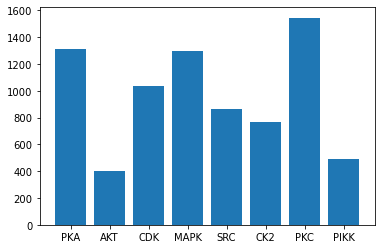

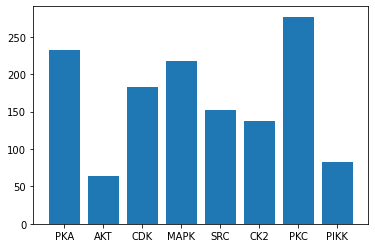

In [33]:
import numpy as np

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(range(len(motifs)), test_size=0.15, random_state=666)
print(len(X_train), len(X_test))

X_tr = motifxFamMatrix[X_train]
X_te = motifxFamMatrix[X_test]

def get_iterx_sums(X):
    to_plot = []
    for i,col in enumerate(X.T):
        to_plot.append([fams[i], np.sum(col)])
    return to_plot

train_plot = get_iterx_sums(X_tr)
test_plot = get_iterx_sums(X_te)

for fi, fam in enumerate(fams):
    print(fam, train_plot[fi][1], test_plot[fi][1])

from scipy.stats.stats import pearsonr   
print ("\n","Pearson:",pearsonr([x[1] for x in train_plot],[x[1] for x in test_plot]))

import matplotlib.pyplot as plt
%matplotlib inline

y_pos = range(len(fams))
plt.bar(y_pos, [x[1] for x in train_plot])
plt.xticks(y_pos, fams)
plt.show()

plt.bar(y_pos, [x[1] for x in test_plot])
plt.xticks(y_pos, fams)
plt.show()

## Try manual test/train split ...

In [36]:
idc = [x for x in range(len(motifs))]
random.Random(my_seed).shuffle(idc)

test_idc = []
for fi,fam in enumerate(fams):
    test_set_size = int(sum(motifxFamMatrix.T[fi]) * 0.15 )
    positive_idc = [mi for mi in idc if motifxFamMatrix[mi][fi]==1]
    idc_sample = random.Random(my_seed).sample(positive_idc,test_set_size)
    test_idc.extend(idc_sample)
    print("fam:",fam)
test_idc = list(set(test_idc))

# data_dir = "data__for_nerds/"

# df = pandas.DataFrame(test_idc,dtype=int)
# df.to_csv(data_dir + 'test_idc.csv',header=None,index=None)

fam: PKA
fam: AKT
fam: CDK
fam: MAPK
fam: SRC
fam: CK2
fam: PKC
fam: PIKK


(0.9629802238046321, 0.0001233401633600008)


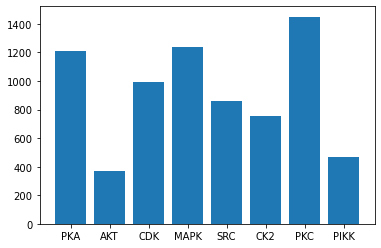

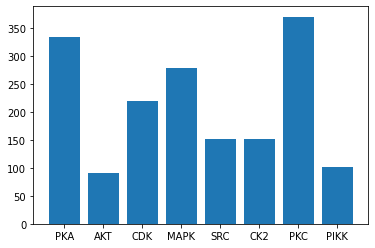

In [37]:
train_idc = [i for i in range(len(motifs)) if i not in test_idc]

X_tr = motifxFamMatrix[train_idc]
X_te = motifxFamMatrix[test_idc]

train_plot = get_iterx_sums(X_tr)
test_plot = get_iterx_sums(X_te)

from scipy.stats.stats import pearsonr   
print (pearsonr([x[1] for x in train_plot],[x[1] for x in test_plot]))

import matplotlib.pyplot as plt
%matplotlib inline

y_pos = range(len(fams))
plt.bar(y_pos, [x[1] for x in train_plot])
plt.xticks(y_pos, fams)
plt.show()

plt.bar(y_pos, [x[1] for x in test_plot])
plt.xticks(y_pos, fams)
plt.show()

## <font color=blue> NOTE: Decided to use automatic test/train split because it gives closer distribution of test to training interactions.

In [34]:
# out_file = open("train_seqs.fasta", "w")
# for i,motif in enumerate(motifs[X_train]):
#     out_file.write(">" + str(i) + "\n" + motif + "\n")
# out_file.close()

# out_file = open("test_seqs.fasta", "w")
# for i,motif in enumerate(motifs[X_test]):
#     out_file.write(">" + str(i) + "\n" + motif + "\n")
# out_file.close()

In [40]:
# df = pandas.DataFrame(motifxFamMatrix[train_idc],dtype=int)
# df.to_csv(data_dir + 'train_motifxFamMatrix.csv',header=None,index=None)

# df = pandas.DataFrame(motifs[train_idc],dtype='U')
# df.to_csv(data_dir + 'train_motifs.csv',header=None,index=None)

# df = pandas.DataFrame(motifxFamMatrix[test_idc],dtype=int)
# df.to_csv(data_dir + 'test_motifxFamMatrix.csv',header=None,index=None)

# df = pandas.DataFrame(motifs[test_idc],dtype='U')
# df.to_csv(data_dir + 'test_motifs.csv',header=None,index=None)

# df = pandas.DataFrame(fams,dtype='U')
# df.to_csv(data_dir + 'fams.csv',header=None,index=None)

In [41]:
df = pandas.DataFrame(motifxFamMatrix,dtype=int)
df.to_csv(data_dir + 'motifxFamMatrix.csv',header=None,index=None)

df = pandas.DataFrame(motifs,dtype='U')
df.to_csv(data_dir + 'motifs.csv',header=None,index=None)